# Image Classification with TensorFlow

## 1 - Exploring the Tensorflow Library

In [26]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.1.0
Eager execution: True


$$loss = \mathcal{L}(\hat{y}, y) = (\hat y^{(i)} - y^{(i)})^2 \tag{1}$$

In [27]:
a = tf.constant(36)
b = tf.constant(39)
loss = tf.Variable(tf.zeros(shape=(1)), name='loss')  # Create a variable for the loss

def compute_loss(y, y_hat):
    return (y - y_hat)**2

print(compute_loss(a, b))
tf.print(compute_loss(a, b))

tf.Tensor(9, shape=(), dtype=int32)
9


In [28]:
a = tf.constant(2)
b = tf.constant(10)
print(tf.multiply(a,b))
tf.print(tf.multiply(a,b))

tf.Tensor(20, shape=(), dtype=int32)
20


### 1.1 - Linear function

Compute $WX + b$

In [29]:
def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- runs the session for Y = WX + b 
    """
    
    np.random.seed(1)
    
    """
    Note, to ensure that the "random" numbers generated match the expected results,
    please create the variables in the order given in the starting code below.
    (Do not re-arrange the order).
    """
    X = tf.constant(np.random.randn(3,1), name = "X")
    W = tf.constant(np.random.randn(4,3), name = "W")
    b = tf.constant(np.random.randn(4,1), name = "b")
    Y = tf.Variable(tf.add(tf.matmul(W, X), b), name='Y')
    
    return Y

In [30]:
tf.print(linear_function())

[[-2.1565738152972127]
 [2.9589144574519342]
 [-1.0892678106543534]
 [-0.84538042215143838]]


### 1.2 - Computing the sigmoid 

In [31]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    results -- the sigmoid of z
    """

    z = tf.cast(z, tf.float32)
    return tf.sigmoid(z, name=None)

In [32]:
tf.print(sigmoid(12))

0.999993801


### 1.3 -  Computing the Cost

$$ J = - \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log a^{ [2] (i)} + (1-y^{(i)})\log (1-a^{ [2] (i)} )\large )\small\tag{2}$$

In [33]:
def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0) 
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits,  labels = labels)
    
    return cost

In [34]:
logits = np.array([0.2,0.4,0.7,0.9], dtype='f')
labels = np.array([0,0,1,1], dtype='f')

cost = cost(logits, labels)
tf.print(cost)

[0.798138857 0.913015246 0.403186023 0.34115386]


### 1.4 - Using One Hot encodings

<img src="tensorflow-images/onehot.png" style="width:600px;height:150px;">

In [35]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    # Create a tf.constant equal to C (depth), name it 'C'
    C = tf.constant(C, name = "C")
    
    # Use tf.one_hot, be careful with the axis
    one_hot_matrix = tf.one_hot(labels, C, 1)
        
    return tf.transpose(one_hot_matrix)

In [36]:
labels = np.array([1,2,3,0,2,1])
one_hot = one_hot_matrix(labels, C = 4)
tf.print(one_hot)

[[0 0 0 1 0 0]
 [1 0 0 0 0 1]
 [0 1 0 0 1 0]
 [0 0 1 0 0 0]]


### 1.5 - Initialize with zeros and ones

In [37]:
def ones(shape):
    """
    Creates an array of ones of dimension shape
    
    Arguments:
    shape -- shape of the array you want to create
        
    Returns: 
    ones -- array containing only ones
    """
    
    # Create "ones" tensor using tf.ones(...)
    ones = tf.ones(shape)
    
    return ones

In [38]:
tf.print(ones([3]))

[1 1 1]


# 2 - Building your first neural network in tensorflow

### 2.1 - Problem statement: SIGNS Dataset

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.
<img src="tensorflow-images/hands.png" style="width:800px;height:350px;"><caption><center> <u><font color='purple'> **Figure 1**</u><font color='purple'>: SIGNS dataset <br> <font color='black'> </center>

In [39]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [40]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


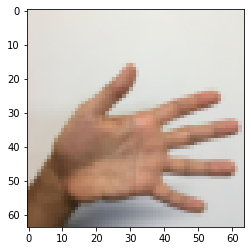

In [41]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [42]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [43]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


### 2.2 - Building the model

In [44]:
class Model(object):
    def __init__(self, X, Y):
        # initialize paramaters
        np.random.seed(1)   # so that your "random" numbers match ours
        
        xavier_initializer = tf.initializers.GlorotUniform()
        zero_initializer = tf.zeros_initializer()

        self.W1 = tf.Variable(xavier_initializer(shape=[25,12288]), dtype='float32')
        self.b1 = tf.Variable(zero_initializer(shape=[25,1]), dtype='float32')
        self.W2 = tf.Variable(xavier_initializer(shape=[12,25]), dtype='float32')
        self.b2 = tf.Variable(zero_initializer(shape=[12,1]), dtype='float32')
        self.W3 = tf.Variable(xavier_initializer(shape=[6,12]), dtype='float32')
        self.b3 = tf.Variable(zero_initializer(shape=[6,1]), dtype='float32')
        
    def __call__(self, X):
        # forward propagation
        self.Z1 = tf.add(tf.matmul(self.W1,X), self.b1)  
        self.A1 = tf.nn.relu(self.Z1)               
        self.Z2 = tf.add(tf.matmul(self.W2,self.A1), self.b2)   
        self.A2 = tf.nn.relu(self.Z2)                                                
        self.Z3 = tf.add(tf.matmul(self.W3,self.A2), self.b3) 
        return self.Z3

In [45]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))

    return cost

In [46]:
def train(model, inputs, outputs):
    """
    Trains the model
    
    Args:
    model -- Model object defined above
    inputs -- X_train input of training data
    outputs -- Y_train output of training data
    
    Returns:
    None
    """
    
    with tf.GradientTape() as t:
        current_loss = compute_cost(model(inputs), outputs) # forward propagate and compute cost
        grads = t.gradient(current_loss, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3])
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3]))
        costs.append(current_loss)
    if epoch % 10 == 0:
        print ("Cost after epoch %i: %f" % (epoch, current_loss))

Cost after epoch 0: 1259.784302
Cost after epoch 10: 27050.927734
Cost after epoch 20: 103098.320312
Cost after epoch 30: 331070.093750
Cost after epoch 40: 862445.687500
Cost after epoch 50: 1901020.000000
Cost after epoch 60: 3708972.750000
Cost after epoch 70: 6593314.500000
Cost after epoch 80: 10895704.000000
Cost after epoch 90: 16983254.000000


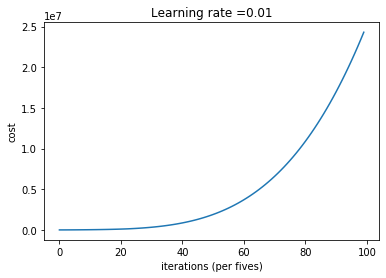

In [47]:
X_train = X_train.astype('float32')
learning_rate = 0.01
costs = []
num_epochs = 100

model = Model(X_train, Y_train) # Initialize variables
optimizer = tf.optimizers.Adam(learning_rate)

for epoch in range(num_epochs):
    train(model, X_train, Y_train)
    
# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()